# Plot EPRs of significant electrodes for cue read listen

In [4]:
import numpy as np
from scipy import stats
import os
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bands_list = ['theta', 'alpha', 'beta1', 'beta2', 'low gamma', 'high gamma']
freq_list=[400]
HS_list=[68, 69, 75, 79, 82, 83, 84, 85, 86]

base_path = '/public/DATA/overt_reading/Blocked_data/'  # 数据基础路径
save_base_path = '/public/DATA/overt_reading/t-test_results/'

cue_time = [400, int((1+1)*400)]
read_time = [1200, int((3+1)*400)]
listen_time = [0, int(1*400)]
task_time = {'Cue': cue_time, 'Read': read_time, 'listen': listen_time}

In [5]:
for task in task_time.keys():
    sig_elecs_list = np.load(os.path.join(save_base_path, 'sig_elecs',f"all_sig_elecs_list_{task}.npy"),allow_pickle=True).item()
    sig_array = np.load(os.path.join(save_base_path, 'sig_elecs',f"all_sig_arrays_{task}.npy"),allow_pickle=True).item()
    print(sig_elecs_list['HS68'])
    print(sig_array['HS68']['theta'][15])
    break

{'theta': [15, 64], 'alpha': [], 'beta1': [13, 14, 30, 31, 112, 142, 252], 'beta2': [159], 'low gamma': [38, 142, 157, 158], 'high gamma': [38, 141, 142, 143, 157, 158, 159, 227]}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

In [43]:

def nansem(a, axis=0):
    return np.nanstd(a, axis=axis) / np.sqrt(a.shape[axis])

def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None, alpha=0.6, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    # print(a.shape)
    # print(xvals.shape)
    mean = np.nanmean(a, axis=0)
    # print(mean.shape)
    
    sem = nansem(a, axis=0)
    # print(sem.shape)
    # print(mean.shape, sem.shape)
    ax.axvline(0, color='gray', linewidth=0.5)
    #ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, color=color, label=label)
    else:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=alpha, label=label)

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return h

def plt_erps_significant_electrodes_with_points(ecog_data, significant_electrodes, sig_array, start_time, end_time, threshold=0.05, title="ERP with Significant Points"):
    """
    绘制 ERP 并在显著电极曲线上标注连续显著点。
    Args:
        ecog_data (ndarray): ERP 数据，形状为 (n_samples, n_electrodes, n_timesteps)。
        significant_electrodes (list): 每个电极的显著时间点 [electrode_idx]。
        sig_array(dict): 每个电极的显著点，shape=[N_TIMESTEPS]
        p_values (ndarray): 每个电极的 p 值数组，形状为 (n_electrodes, n_timesteps)。
        threshold (float): 显著性阈值。
    """
    n_electrodes = ecog_data.shape[1]  # 获取电极数量
    electrode_list = [i for i in range(n_electrodes)]
    n_elec = len(electrode_list)
    print(n_elec)

    fig, axs = plt.subplots(int(n_elec / 8), 8, figsize=(25, int(n_elec * 25 / 128)))
    axs = axs.flatten()  # 将 axs 转换为一维数组，方便索引

    for i, electrode_index in enumerate(electrode_list):
        # 提取 ERP 数据
        data_erp = ecog_data[:, electrode_index, int(start_time - 80):int(end_time)]
        # print(data_erp.shape)
        # mean_erp = np.nanmean(data_erp, axis=0)  # 计算均值 ERP
        # sem_erp = np.nanstd(data_erp, axis=0) / np.sqrt(data_erp.shape[0])  # 计算标准误差
        xval = np.linspace(-0.2, 1, (end_time-start_time+80))  # 创建时间轴

        plot_filled_sem(data_erp, xvals=xval, ax=axs[i], color='red' if electrode_index in significant_electrodes else 'blue', label='cue')
        # plot_filled_sem(read_erp, xvals=xval, ax=axs[i], color='red' if electrode_index in significant_electrodes else 'orange', label='read')
        # plot_filled_sem(read_erp, xvals=xval, ax=axs[i], color='red' if electrode_index in significant_electrodes else 'green', label='listen')

        # # 绘制平均 ERP 曲线
        # axs[i].plot(xval, mean_erp, color='red' if electrode_index in significant_electrodes else 'blue', label='ERP')
        # axs[i].fill_between(xval, mean_erp - sem_erp, mean_erp + sem_erp, alpha=0.2, color='red' if electrode_index in significant_electrodes else 'blue')

        # 标注显著时间点
        if electrode_index in significant_electrodes:
            timepoints = sig_array[electrode_index]
            # significant_points = np.where(timepoints == 1)[0]
            # 显著点索引（修正为 data_erp 时间轴范围）
            significant_points = np.where(sig_array == 1)[0]  # 获取显著点索引
            adjusted_significant_points = significant_points + 80  # 修正索引偏移（从 0s 开始）
            adjusted_significant_points = adjusted_significant_points[adjusted_significant_points >= 0]  # 过滤负索引
            adjusted_significant_points = adjusted_significant_points[adjusted_significant_points < data_erp.shape[1]]  # 过滤超出范围的索引

            # 显著点对应时间轴
            sig_times = xval[adjusted_significant_points]

            # 标注显著点
            axs[i].scatter(sig_times,
               np.nanmean(data_erp, axis=0)[adjusted_significant_points] + 0.2,
               color='black', marker='*', s=20, label='Significant Points')
            # sig_times = xval[significant_points]
            # print(f"sig_array.shape: {sig_array.shape}")
            # print(f"data_erp.shape: {data_erp.shape}")
            # print(f"significant_points: {significant_points}")

            # axs[i].scatter(sig_times, data_erp[significant_points] + 0.05, color='black', marker='*', s=10, label='Significant Points')
        
        axs[i].axvline(0, color='gray', linewidth=0.5)
        
        # 设置子图的标题和标签
        axs[i].set_title(f'Electrode {electrode_index}', fontsize=8)
        axs[i].legend(loc='upper right', fontsize='small', frameon=True)
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Amplitude (a.u.)')

    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

def load_band_data(data_path, HS, band):
    keys = ['功课', '力果', '宫客', '作业', '树叶', '对十', '数页', '绿草', 'gōng kè', 'shù yè', ]

    # 加载每个 band 的 block 数据
    file_path = os.path.join(data_path, f"HS{HS}block_{band}.npy")
    block_data = np.load(file_path, allow_pickle=True).item()

    for key in keys:
        if key in block_data:
            data = block_data[key]  # data 是一个长度为 256 的列表，每个元素 shape 为 (time2200, trials)
            reshaped_data = np.array([elec_data.T for elec_data in data])  # (electrodes, trials, time)
            reshaped_data = reshaped_data.transpose(1, 0, 2)  # (trials, electrodes, time)
    
    return reshaped_data

256


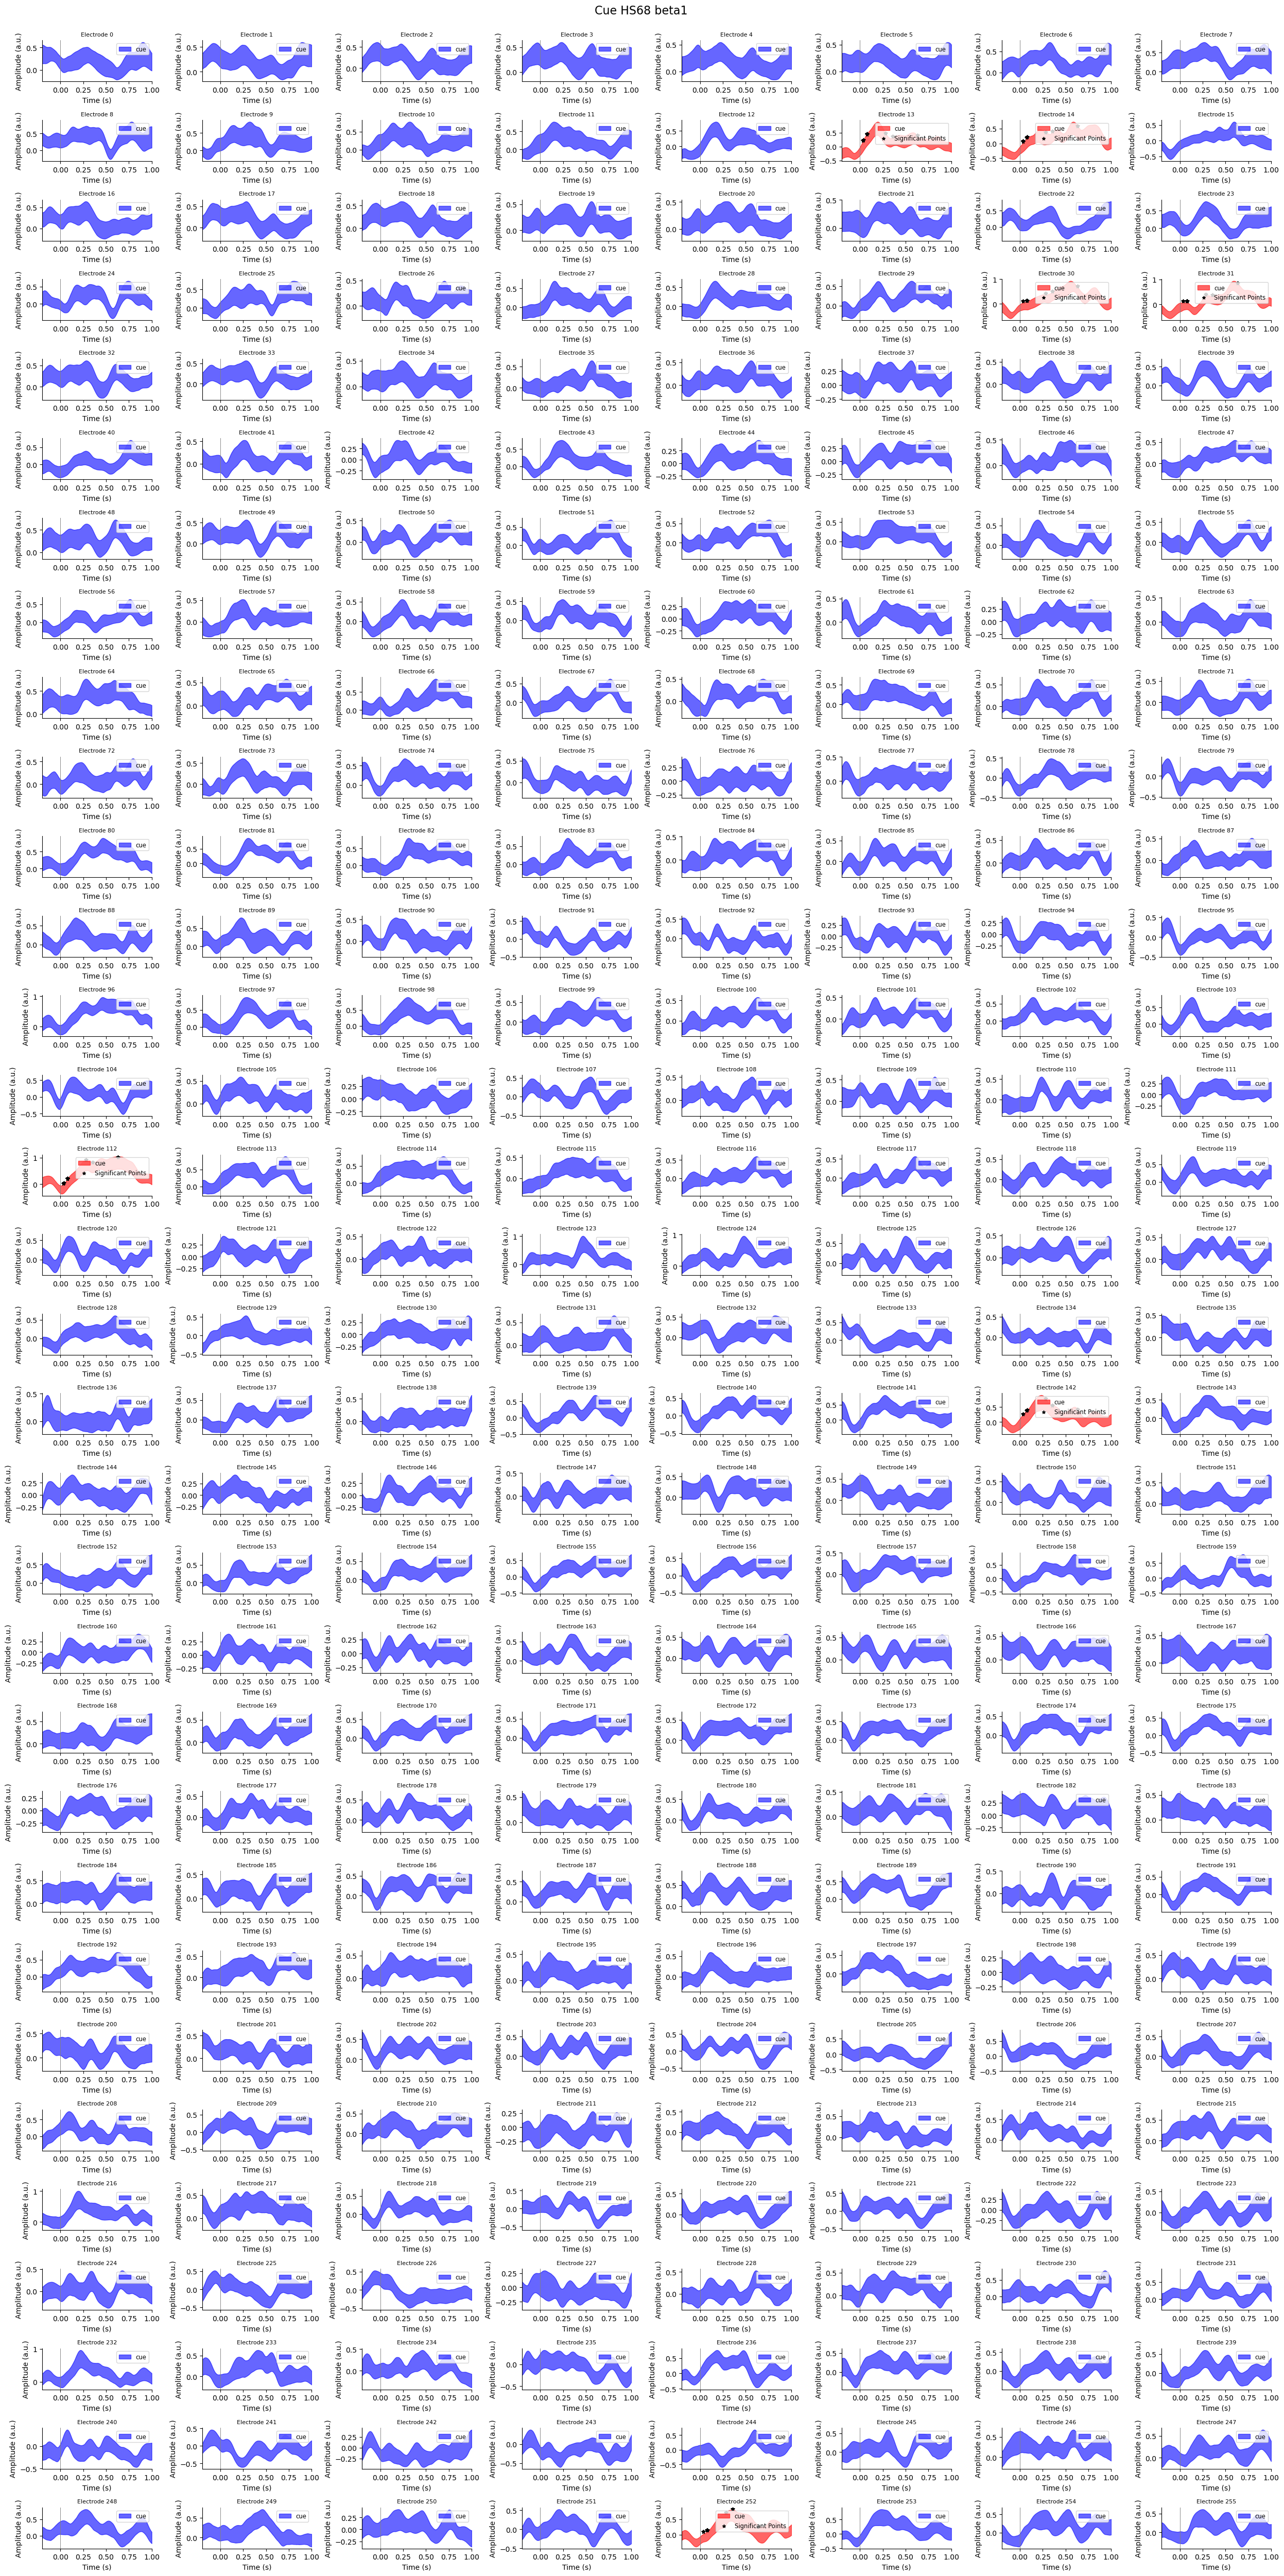

256


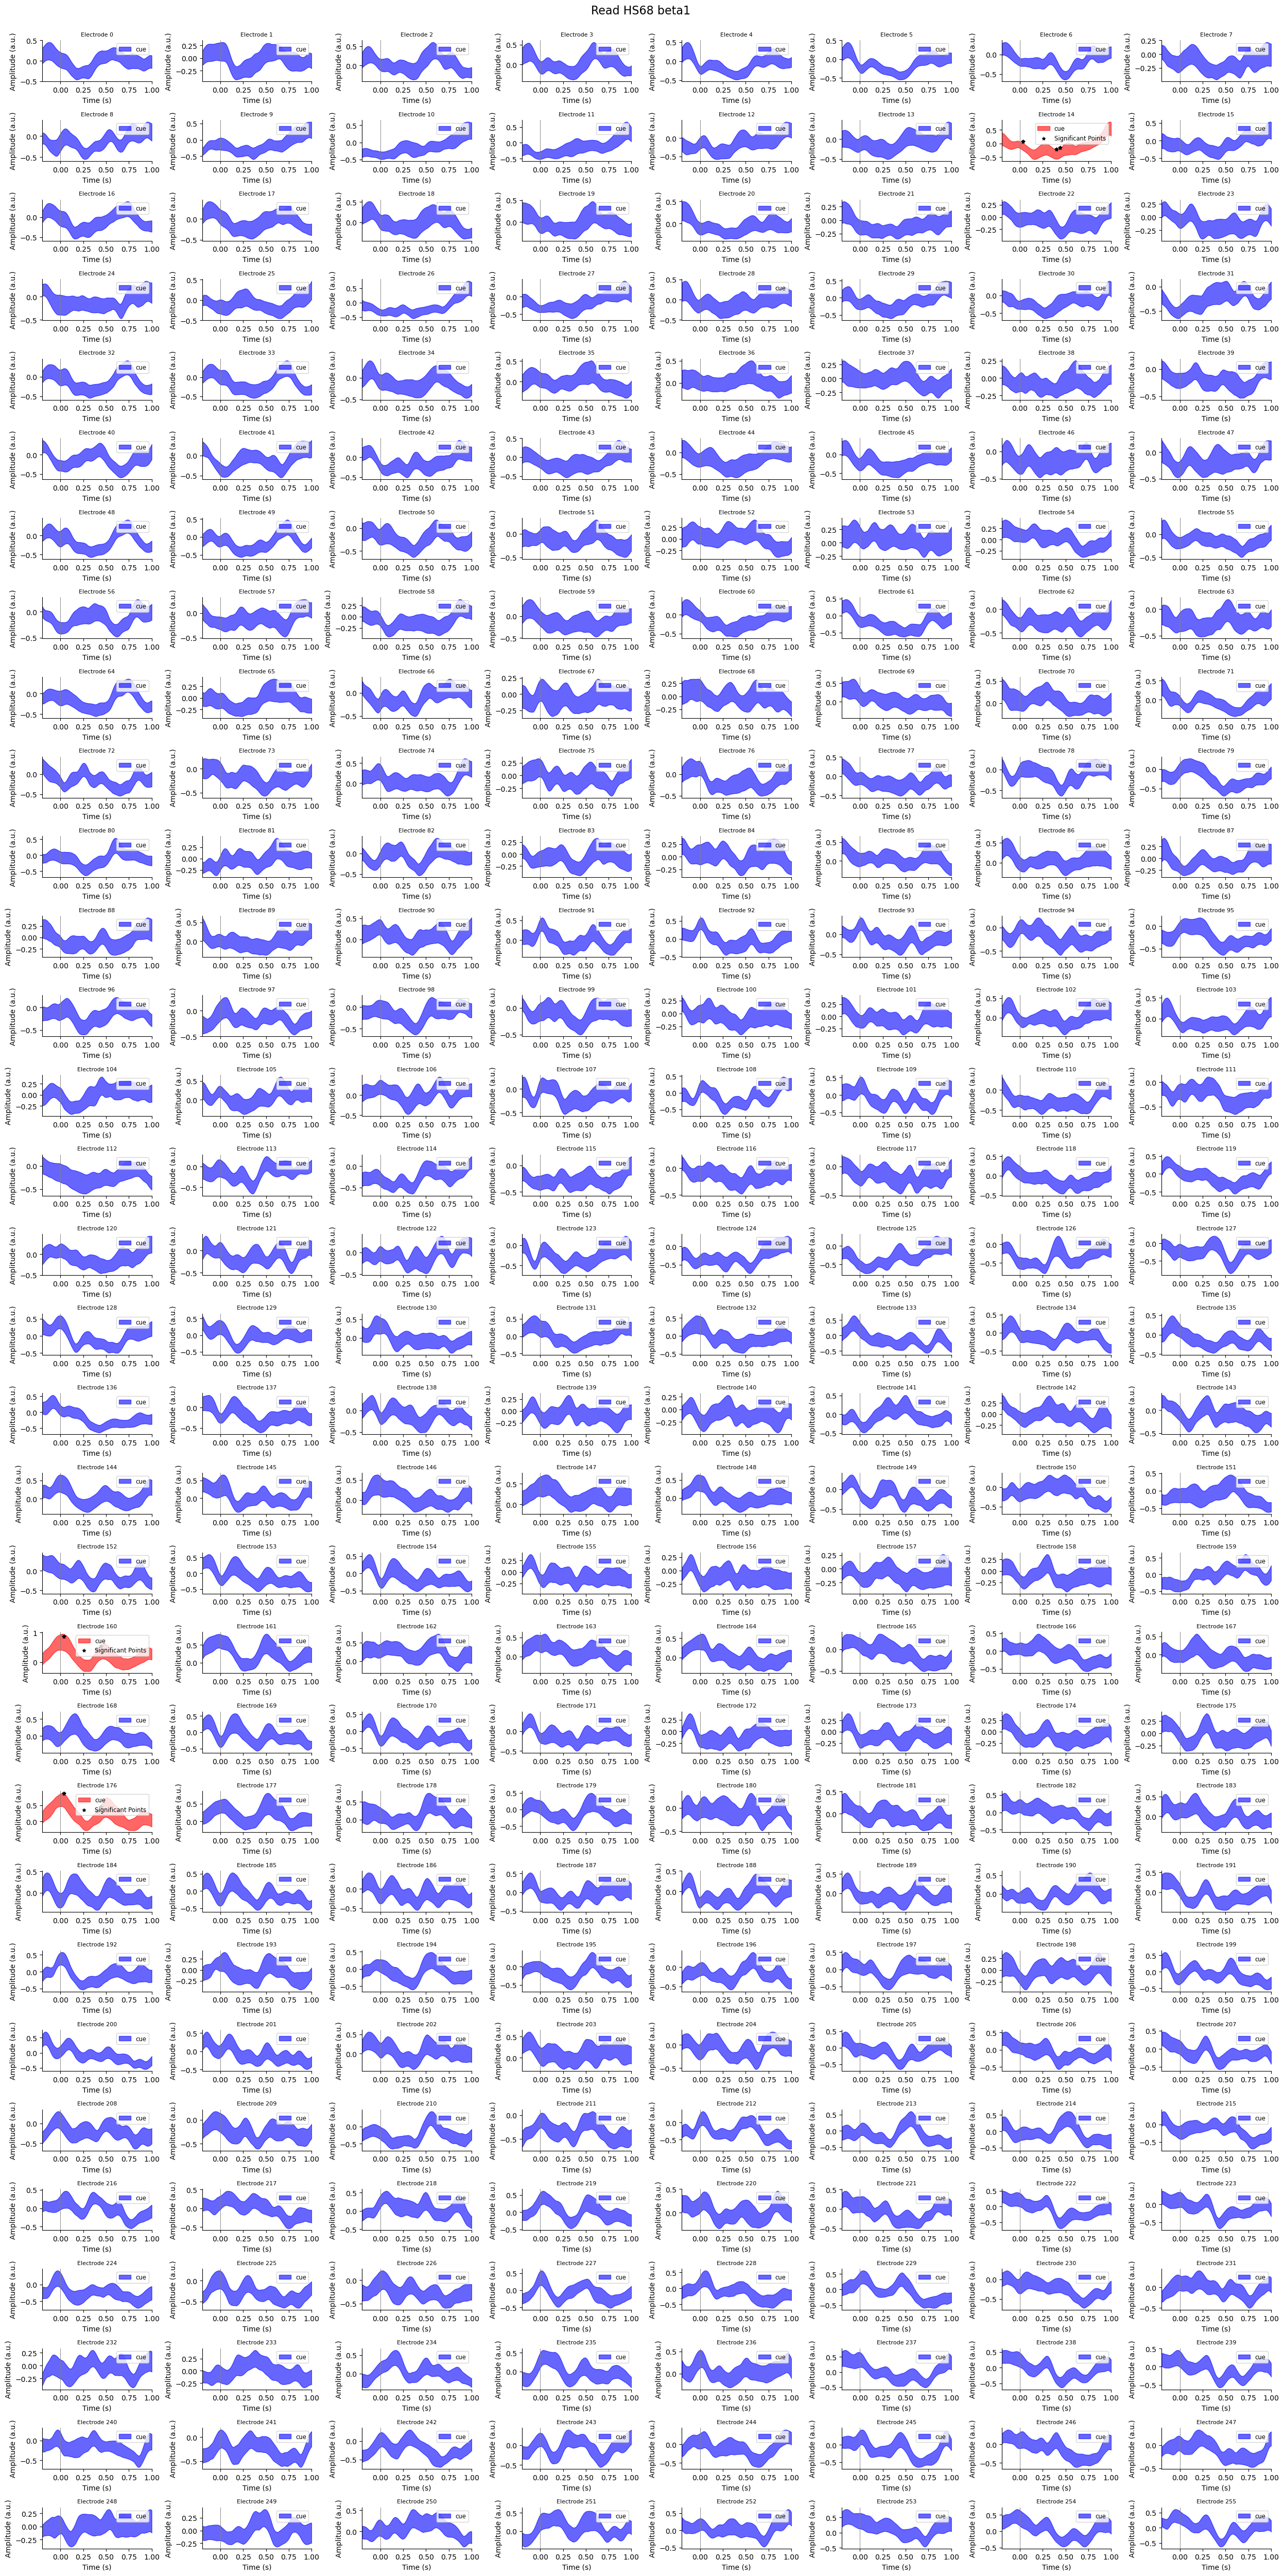

In [45]:
for HS in HS_list:
    for band in bands_list:
        band = 'beta1'
        band_ecog_data = load_band_data(base_path, HS, band)
        for task, time in task_time.items():
            if task == 'listen':
                continue
            sig_elecs_list = np.load(os.path.join(save_base_path, 'sig_elecs',f"all_sig_elecs_list_{task}.npy"),allow_pickle=True).item()
            sig_array = np.load(os.path.join(save_base_path, 'sig_elecs',f"all_sig_arrays_{task}.npy"),allow_pickle=True).item()
            plt_erps_significant_electrodes_with_points(band_ecog_data, sig_elecs_list[f'HS{HS}'][band], sig_array[f'HS{HS}'][band], time[0], time[1], threshold=0.05, title=f"{task} HS{HS} {band}")
            # break
        break
    break